In [10]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import requests
%matplotlib inline

In [408]:
def get_playergames(rank=19):
    url = "https://calculated.gg/api/v1/playergames?key=1&rank={}&playlist=13".format(rank)
    r = requests.get(url)
    return r.json()

def get_playergames_by_id(id_="76561198018756583", all_=False, days=30):
    url = "https://calculated.gg/api/v1/playergames?key=1&player_ids={}&playlist=13&days={}".format(id_, days)
    r = requests.get(url)
    print(url)
    js = r.json()
    if not all_:
        js['data'] = [d for d in js['data'] if d[2] == id_]
    return js

smurfs = ['76561198142512330', '76561198867867878', '76561198039062964']

In [241]:
def concat_data(rank_datas):
    input_data = None
    for rank_data in rank_datas:
        data = pd.DataFrame(rank_data['data'], columns=rank_data['columns']).fillna(0)
        if input_data is not None:
            input_data = input_data.append(data)
        else:
            input_data = data
    return input_data.reset_index()
datas = []
for rank in range(10, 20):
    for x in range(5):
        rank_data = get_playergames(rank)
        datas.append(rank_data)
            
input_data = concat_data(datas)

In [268]:


input_data.head()

,index,id,name,player,game,rank,division,mmr,is_orange,win,...,time_closest_to_team_center,time_furthest_from_team_center,is_bot,first_frame_in_game,time_in_game,time_in_front_of_center_of_mass,time_behind_center_of_mass,time_most_forward_player,time_most_back_player,time_between_players
0,0,1511218,dunkphat,76561197968853721,A7A2B24C11E8CDEAF36DB4B695A970F4,10,2,748,True,True,...,0.00000,0.000000,False,1.0,311.794128,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1846453,dunkphat,76561197968853721,DF1857B411E8D104D40F24971E6114F5,10,3,758,False,False,...,0.00000,0.000000,False,1.0,320.648499,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2358199,felagund9,76561198104052806,7E75A22411E8DA352CC87B812D90E774,10,1,640,False,False,...,58.87915,39.764526,False,1.0,322.324982,145.612656,176.712341,105.340714,127.388824,89.595444
3,3,1265012,Floboss le Francais,76561197991597902,AF6C467949A99892969057B3C25493DD,10,0,637,False,False,...,0.00000,0.000000,False,1.0,364.692932,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1029522,Callanmari,76561198169600688,06BC313943F0863B6A17C3A68D3B78E5,10,3,760,False,True,...,0.00000,0.000000,False,1.0,336.128082,0.000000,0.000000,0.000000,0.000000,0.000000


In [590]:

def process_input_data(input_):
    input_columns = ['saves', 'total_aerials', 
                     'time_at_boost_speed', 'time_at_slow_speed', 'average_speed', 
                     'boost_usage', 'average_hit_distance', 'ball_hit_forward', 'won_turnovers',
                     'num_stolen_boosts']#
    ignore = ['total_saves', 'is_bot', 'time_in_game', 'car']
    input_columns = list(input_.columns[11:])
    nonzero = input_[input_['time_in_game'] > 0]
    input = nonzero[input_columns].div(nonzero['time_in_game'], axis=0)
    input = input.drop(ignore, axis=1)
#     for c in input.columns:
#         if (input[c].max()-input[c].min()) == 0:
#             print(c)
#             input = input.drop(c, axis=1)
    input = (input-input.min())/(input.max()-input.min())
    output = nonzero['rank'].values.reshape((-1, 1)).astype(float)
    return input, output
input, output = process_input_data(input_data)

In [341]:
threshold = np.random.rand(len(output)) < 0.9
input_train, input_test = input[threshold].values.astype(float), input[~threshold].values.astype(float)
output_train, output_test = output[threshold], output[~threshold]

In [342]:
num_columns = len(input.columns)
n_hidden = 128
class RankPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, n_hidden//4),
            nn.ReLU(),
            nn.Linear(n_hidden//4, 1)
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

In [343]:
model = RankPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-2)
loss = nn.MSELoss()
epochs = 10000
epoch_losses = []
accuracy = []


output_tensor = torch.from_numpy(output_train).float().cuda()

for epoch in range(epochs):
    opt.zero_grad()
    predicted = model(input_train)
    loss_val = loss(predicted, output_tensor)
    loss_val.backward()
    opt.step()
    
    predicted = model(input_test)
    predicted = predicted.cpu().detach().numpy().astype(float)
#     print(predicted.shape, output_test.shape)
#     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
    acc = (abs(predicted.astype(float) - output_test.astype(float)) < 3).sum() / predicted.shape[0]
    epoch_losses.append(loss_val.cpu().data.numpy())
    accuracy.append(acc)

KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(epoch_losses)), epoch_losses);

In [ ]:
plt.plot(range(len(accuracy)), accuracy);

In [ ]:
d = []
for x in range(0, len(input_test), 10):
    d.append(model(input_test[x: x+100].astype(float)).mean())
    
plt.plot(np.array(range(len(d))) / 50 + 10, d)
plt.xlabel('Actual rank')
plt.ylabel('Predicted rank')
plt.xticks(list(range(12, 19)))
plt.yticks(list(range(12, 19)));
plt.grid();

In [ ]:
input.shape

In [ ]:
accuracy[-1]

# Ensemble Model

In [344]:
num_columns = len(input.columns)
n_hidden = 32
class RankPredictorEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

[0, 1, 1, 1, 1, 1]


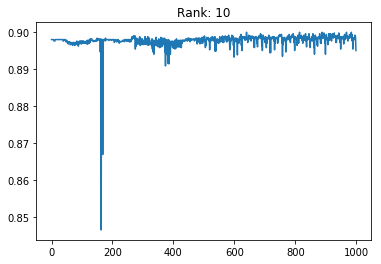

[0, 1, 1, 1, 1, 1]


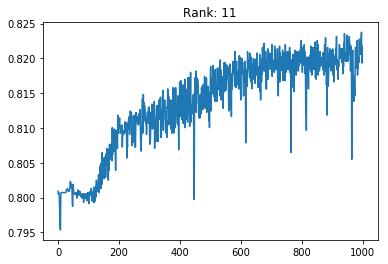

[0, 0, 1, 1, 1, 1]


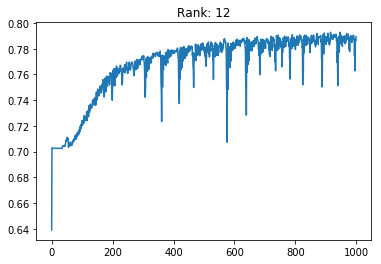

[0, 0, 1, 1, 1, 1]


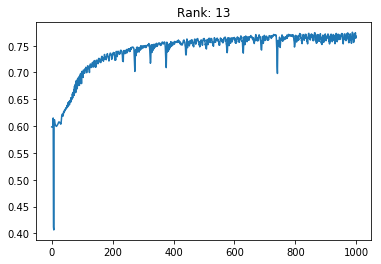

[0, 0, 0, 1, 1, 1]


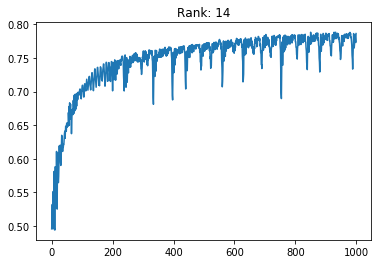

[0, 0, 0, 1, 1, 1]


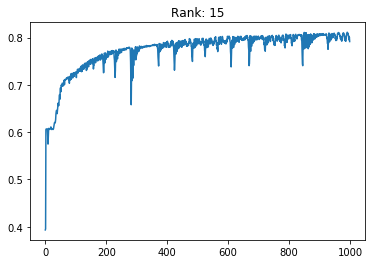

[0, 0, 0, 0, 1, 1]


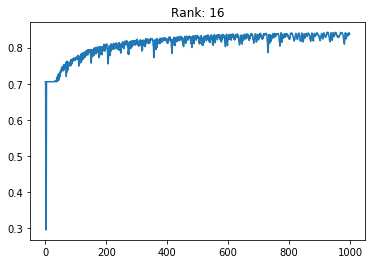

[0, 0, 0, 0, 1, 1]


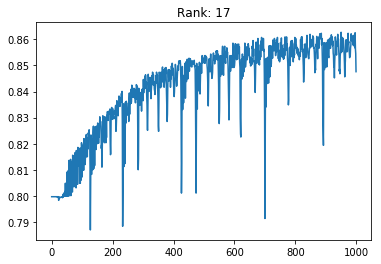

[0, 0, 0, 0, 0, 1]


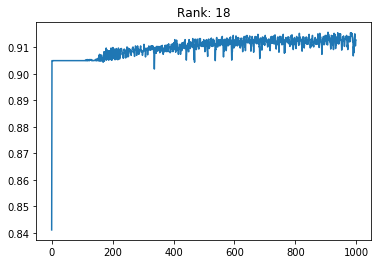

[0, 0, 0, 0, 0, 0]


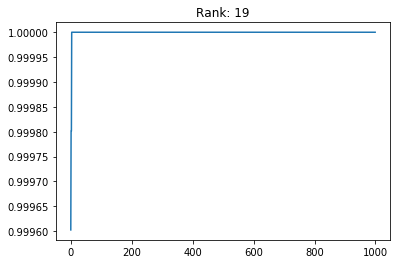

In [345]:
ranks = list(range(10, 20))
models = {}
for rank in ranks:
    models[rank] = RankPredictorEnsemble().cuda()
for rank, model in models.items():
#     if rank != 15:
#         continue
    opt = optim.Adam(model.parameters(), lr=1e-2)
    loss = nn.BCELoss()
    epochs = 1000
    epoch_losses = []
    accuracy = []

    out = (output_train > rank).astype(int)
    print([out[n][0] for n in range(0, len(output_train), len(output_train)//5)])
    output_tensor = torch.from_numpy(out).cuda().float()
    for epoch in range(epochs):
        opt.zero_grad()
        predicted = model(input_train)
        loss_val = loss(predicted, output_tensor)
        loss_val.backward()
        opt.step()

        predicted = model(input_test)
        predicted = predicted.cpu().detach().numpy().astype(float)
    #     print(predicted.shape, output_test.shape)
    #     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
        acc = ((predicted > 0.5).astype(int) == (output_test > rank).astype(int)).sum() / predicted.shape[0]
        epoch_losses.append(loss_val.cpu().data.numpy())
        accuracy.append(acc)
    plt.plot(range(len(accuracy)), accuracy);
    plt.title('Rank: {}'.format(rank));
    plt.show();

In [346]:
df_test = None
for rank, model in models.items():
    predicted = pd.Series(model(input_test).detach().cpu().numpy().reshape(len(input_test)), name=str(rank))
    if df_test is None:
        df_test = predicted.to_frame()
    else:
        df_test = df_test.merge(predicted.to_frame(), left_index=True, right_index=True)

In [347]:
df_test.head()

,10,11,12,13,14,15,16,17,18,19
0,0.540462,0.325673,0.310011,0.147984,0.070170,0.055298,0.021839,0.011667,0.001310,0.0
1,0.847718,0.652509,0.520023,0.523381,0.328325,0.108340,0.049741,0.020448,0.004197,0.0
2,0.524636,0.522400,0.403927,0.311598,0.058366,0.057928,0.033120,0.045559,0.065224,0.0
3,0.836448,0.884656,0.805257,0.837214,0.625985,0.690445,0.357453,0.290970,0.101863,0.0
4,0.776812,0.586995,0.480051,0.316674,0.182572,0.108715,0.038767,0.020169,0.003582,0.0


In [348]:
results = df_test.apply(lambda x: x > 0.5).apply(lambda x: int(x.idxmin()), axis=1).values

Text(0, 0.5, 'Predicted Rank')

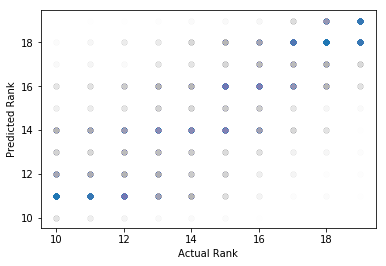

In [349]:
plt.scatter(output_test.reshape(output_test.shape[0]), results, alpha=0.005)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')

In [354]:
d = []
for i in range(15):
    d.append((abs(results - output_test.reshape(output_test.shape[0])) <= i).sum() * 100 / results.shape[0])
d = pd.DataFrame(d, columns = ['Accuracy (%)'])
d.index.name = 'Rank Difference'
d

,Accuracy (%)
Rank Difference,
0,23.087622
1,60.242400
2,78.581363
3,89.787403
4,95.966620
5,98.132327
6,99.443672
7,99.880787
8,100.000000


In [422]:
# smurf_data = concat_data([get_playergames_by_id(smurfs[2])])
# smurf_data = concat_data([get_playergames_by_id('76561198060924319')])
# smurf_data = concat_data([get_playergames_by_id('76561198055442516')])
smurf_data = concat_data([get_playergames_by_id('76561197992682099')])

smurf_data

https://calculated.gg/api/v1/playergames?key=1&player_ids=76561197992682099&playlist=13&days=30


,index,id,name,player,game,rank,division,mmr,is_orange,win,...,time_closest_to_team_center,time_furthest_from_team_center,is_bot,first_frame_in_game,time_in_game,time_in_front_of_center_of_mass,time_behind_center_of_mass,time_most_forward_player,time_most_back_player,time_between_players
0,0,1926656,CorruptedG,76561197992682099,737245B211E8D1C01F441D93CE788AEF,19,0,1570,True,False,...,76.285492,25.516151,False,1,316.683105,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2280591,CorruptedG,76561197992682099,AC25F35A11E8D72D7B426E8B6A3A4A60,19,0,1645,False,True,...,72.441048,20.536903,False,1,319.386444,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,1984368,CorruptedG,76561197992682099,1250A80011E8D247E993E3A0E1517F09,19,0,1734,True,False,...,0.000000,0.000000,False,1,323.215607,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,2415056,CorruptedG,76561197992682099,4E0F1DC811E8DC828ACD30A07597FDD4,19,0,1703,False,True,...,83.874092,20.201830,False,1,357.592102,187.077820,170.514282,121.785156,124.780144,111.026802
4,4,2280307,CorruptedG,76561197992682099,8FE6C37E11E8D72BF6B26E8B705CB0BC,19,0,1645,False,False,...,79.470146,44.426254,False,1,358.820129,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,2312425,CorruptedG,76561197992682099,9FC51B8E11E8D888396DFB8A68244BC6,19,0,1868,False,True,...,0.000000,0.000000,False,1,339.367737,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,1498894,CorruptedG,76561197992682099,834EE2F011E8C9ABD5514A91DFFAAFCB,19,0,1558,False,True,...,71.580940,17.121521,False,1,315.177673,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,1498995,CorruptedG,76561197992682099,CFADFCC211E8C9AF66EB4A919DB5566D,19,0,1558,False,False,...,74.547325,25.207628,False,1,314.491699,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,1498810,CorruptedG,76561197992682099,AE01BB0211E8C9AC87EF4A91777CAF14,19,0,1558,False,True,...,76.840515,7.734396,False,1,320.613831,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,1803664,CorruptedG,76561197992682099,16DDCCFA11E8CF444EA4C3A195DACF62,19,0,1561,True,False,...,73.591843,12.885868,False,1,317.122864,0.000000,0.000000,0.000000,0.000000,0.000000


In [423]:
point = process_input_data(smurf_data)[0].values

In [428]:
result = pd.DataFrame(index=list(range(len(point))))
for rank, m in models.items():
    result = result.merge(pd.Series(100 * m(point.astype(float)).detach().cpu().numpy().reshape(len(smurf_data)), name=str(rank)).to_frame(), left_index=True, right_index=True)
result = (result > 50).apply(lambda x: int(x.idxmin()), axis=1).values
result

array([19, 19, 16, 18, 19, 18, 19, 18, 19, 19, 18, 19, 19, 18, 18, 18, 18,
       18, 19, 19, 18, 19, 18, 18, 18, 19, 19, 19, 18, 19, 18, 17, 18, 18,
       19, 19])

In [429]:
print(result.mean())
round(result.mean())

18.38888888888889


18.0

# PCA

In [591]:
k = 3

In [592]:
input.shape

(49814, 67)

In [593]:
def PCA(data, offset=0, k=2):
    # preprocess the data
    X = torch.from_numpy(data.values.astype(float))
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)

    # svd
    U,S,V = torch.svd(torch.t(X))
    print(S.round(), S.max(), S.argmax())
    print(U.shape, S.shape, V.shape)
    print (U[0, :50].argmax())
    return torch.mm(X,U[:,offset:offset + k])
def PCA_col(data, columns=[18, 19]):
    # preprocess the data
    X = torch.from_numpy(data.values.astype(float))
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)

    # svd
    U,S,V = torch.svd(torch.t(X))
#     print(U.shape)
    return torch.mm(X,U[:,columns])

Text(0, 0.5, 'average_speed')

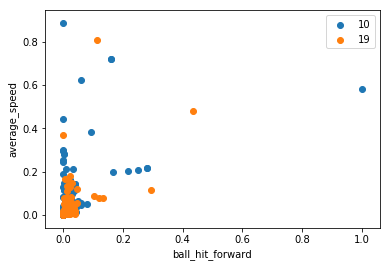

In [601]:
mi = U[:, 0].numpy().argsort() - 1
important = input.columns[mi]
for i in [10, 19]:
    plt.scatter(input[ranks == i][important[0]], input[ranks == i][important[1]], label=str(i))
plt.legend()
plt.xlabel(important[0])
plt.ylabel(important[1])

tensor([31., 21., 16., 15., 13., 10., 10.,  9.,  8.,  8.,  7.,  7.,  6.,  6.,
         5.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  3.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       dtype=torch.float64) tensor(30.5607, dtype=torch.float64) tensor(0)
torch.Size([67, 67]) torch.Size([67]) torch.Size([9947, 67])
tensor(38)


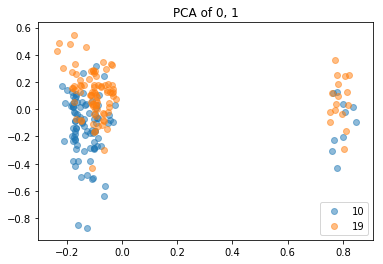

In [595]:
ranks = output.reshape(len(output))
pred = (ranks == 10) | (ranks == 19)
for offset in range(68):
#     offset = 2
    k = 2
    X_PCA = PCA(input[pred], offset=offset, k=k)
    plt.figure()
    y = torch.from_numpy(ranks[pred])
    n = 100
    for i in [10, 19]:#range(10, 20):
        plt.scatter(X_PCA[y == i, 0][:n], X_PCA[y == i, 1][:n], label=str(i), alpha=0.5)

    plt.legend()
    plt.title('PCA of ' + ", ".join([str(s) for s in list(range(offset, offset + k))]))
    plt.show()
    break

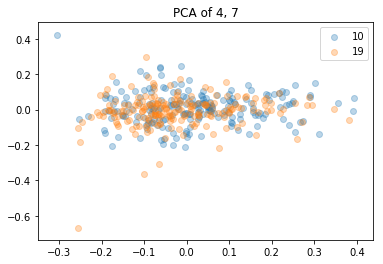

In [596]:
ranks = output.reshape(len(output))
pred = (ranks == 10) | (ranks == 19)
columns=[4, 7]
k = 2
X_PCA = PCA_col(input[pred], columns=columns)
plt.figure()
y = torch.from_numpy(ranks[pred])
n = 200
for i in [10, 19]:#range(10, 20):
    plt.scatter(X_PCA[y == i, 0][:n], X_PCA[y == i, 1][:n], label=str(i), alpha=0.3)

plt.legend()
plt.title('PCA of ' + ", ".join([str(s) for s in columns]))
plt.show()

In [597]:
(ranks == 10).sum()
(ranks == 19).sum()

4980

In [459]:
X_PCA[, :]

tensor([], dtype=torch.float64)

In [456]:
y.shape

(49814,)

In [461]:
(X_PCA[:, 0] == 0).shape

torch.Size([49814])